# Low-Pass Filtering IMU Sample Data
This notebook loads the synthetic Sensor data from the Seeed Studio XIAO nRF52840 Sense Plus, applies a simple first-order low-pass filter to the motion signals, and visualizes the noise reduction.

## Imports and Configuration
We'll use pandas/numpy for data wrangling and Matplotlib for visualization.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

plt.style.use('seaborn-v0_8')


## Load the IMU Sample
The CSV stores 10 seconds of data sampled at 50 Hz.

In [17]:
DATA_PATH = Path('/Users/erickli/Desktop/Machine-Learning-for-Smart-Fitness-Pod/data/raw/run.csv')
FS = 100.0  # sampling frequency in Hz for the wrist IMU

df = pd.read_csv(DATA_PATH)
df.head()


,loop,trig_cnt,accel_x_ms2,accel_y_ms2,accel_z_ms2,gyro_x_dps,gyro_y_dps,gyro_z_dps
0,0,0,0.12237,-0.09932,-9.79393,10.07163,-14.52184,-0.88451
1,1,0,0.12388,-0.07545,-9.76721,11.27120,-11.33460,2.15985
2,2,0,0.14593,-0.05377,-9.62172,7.94428,-11.47829,-0.05696
3,3,0,0.14176,-0.02450,-9.64089,13.70520,-12.20728,3.07916
4,4,0,0.13542,-0.00000,-9.53641,12.61413,-12.65689,3.35395


## Define a Low-Pass Filter
We implement a first-order infinite impulse response (IIR) low-pass filter based on an RC network. It attenuates frequencies above the chosen cutoff while preserving lower-frequency motion.

In [18]:
def low_pass_filter(signal: np.ndarray, cutoff_hz: float, fs: float) -> np.ndarray:
    """Apply a simple first-order low-pass filter."""
    dt = 1.0 / fs
    rc = 1.0 / (2 * np.pi * cutoff_hz)
    alpha = dt / (rc + dt)
    filtered = np.zeros_like(signal)
    filtered[0] = signal[0]
    for i in range(1, len(signal)):
        filtered[i] = filtered[i - 1] + alpha * (signal[i] - filtered[i - 1])
    return filtered

cutoff_hz = 5.0  # adjust based on how aggressive you want the smoothing
columns_to_filter = [
    'accel_x_ms2', 'accel_y_ms2', 'accel_z_ms2',
    'gyro_x_dps', 'gyro_y_dps', 'gyro_z_dps'
]


filtered_df = df.copy()
for column in columns_to_filter:
    filtered_df[column] = low_pass_filter(df[column].to_numpy(), cutoff_hz, FS)


## Compare Raw vs Filtered Signals
We'll plot accelerometer and gyroscope data to see the smoothing effect of the filter.

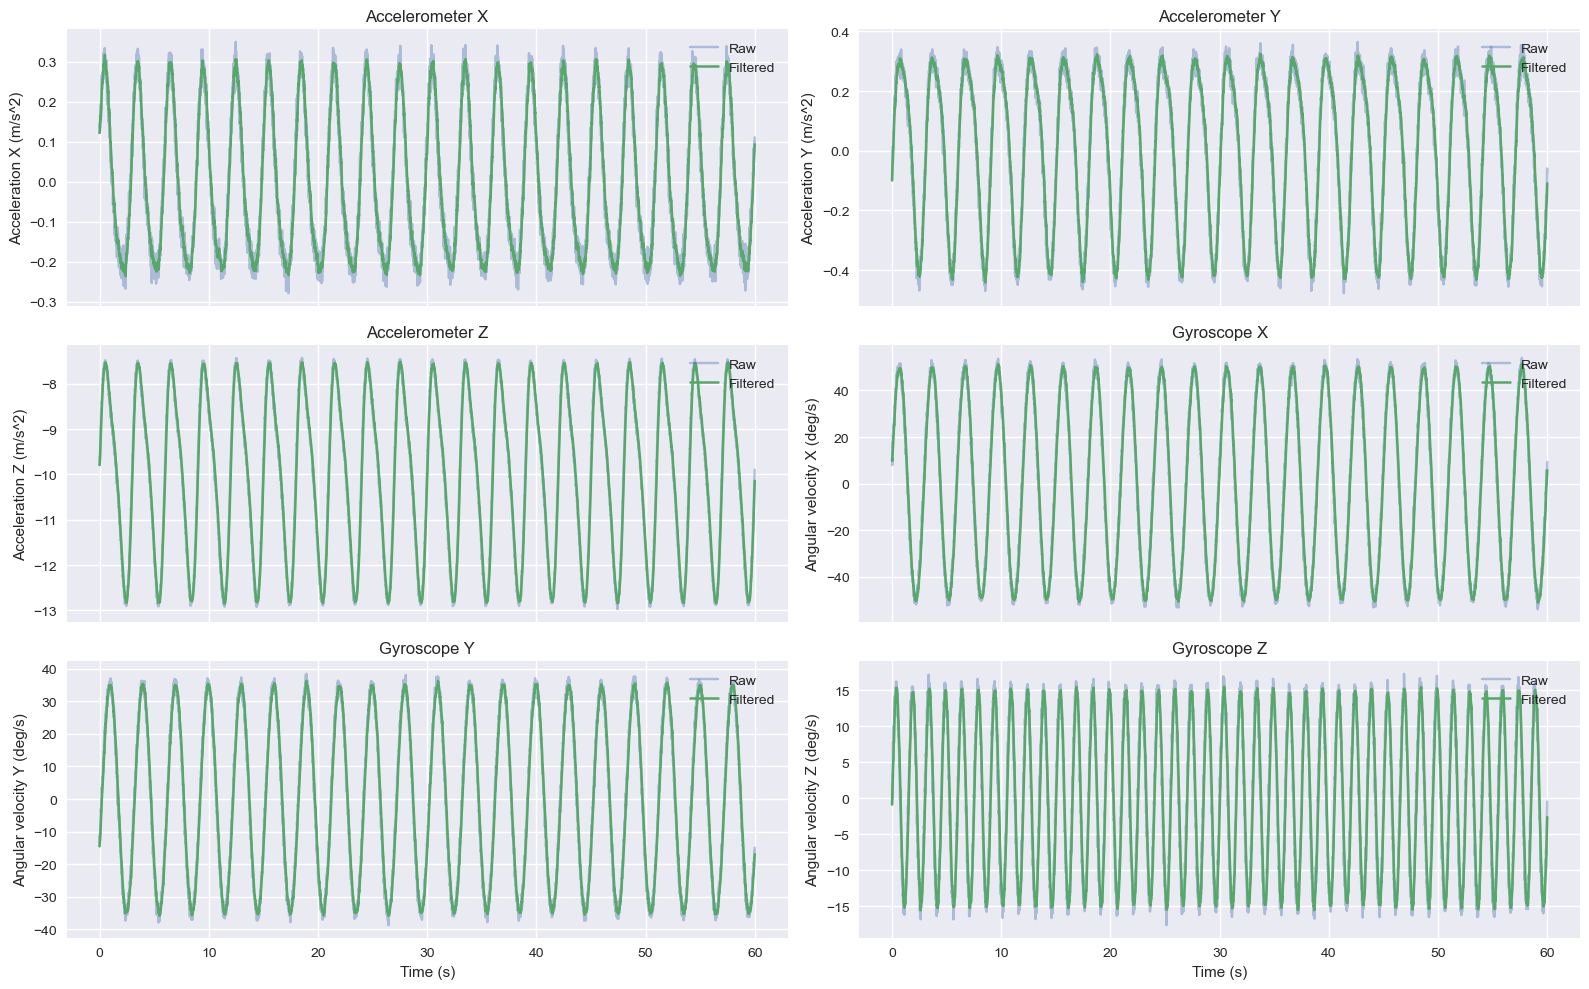

In [19]:
time_s = df['loop'] / FS

axis_configs = [
    ('accel_x_ms2', 'Acceleration X (m/s^2)', 'Accelerometer X'),
    ('accel_y_ms2', 'Acceleration Y (m/s^2)', 'Accelerometer Y'),
    ('accel_z_ms2', 'Acceleration Z (m/s^2)', 'Accelerometer Z'),
    ('gyro_x_dps', 'Angular velocity X (deg/s)', 'Gyroscope X'),
    ('gyro_y_dps', 'Angular velocity Y (deg/s)', 'Gyroscope Y'),
    ('gyro_z_dps', 'Angular velocity Z (deg/s)', 'Gyroscope Z'),
]

fig, axes = plt.subplots(3, 2, figsize=(16, 10), sharex=True)
axes = axes.flatten()

for ax, (column, ylabel, title) in zip(axes, axis_configs):
    ax.plot(time_s, df[column], label='Raw', alpha=0.4)
    ax.plot(time_s, filtered_df[column], label='Filtered', linewidth=1.8)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend(loc='upper right')

for ax in axes[-2:]:
    ax.set_xlabel('Time (s)')

fig.tight_layout()
plt.show()


## Save Filtered Output (Optional)
You can persist the filtered signals for downstream processing.

In [ ]:
OUTPUT_PATH = Path('/Users/erickli/Desktop/Machine-Learning-for-Smart-Fitness-Pod/data/processed/filtered.csv')
filtered_df.to_csv(OUTPUT_PATH, index=False)
OUTPUT_PATH

PosixPath('/Users/erickli/Desktop/Machine-Learning-for-Smart-Fitness-Pod/data/processed/xiao_nr52840_sense_imu_sample_filtered.csv')